In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pytorch-metric-learning


In [3]:

import pandas as pd
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = "/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES.csv"
df = pd.read_csv(file_path)
print(df.head())

NUM_CLASSES = len(df['date'].unique().tolist())

print("Number of classes:", NUM_CLASSES)



         artist  date                  genre  pixelsx  pixelsy  size_bytes  \
0  Paul Gauguin  1903         genre painting   1916.0   1688.0    363138.0   
1  Paul Gauguin  1893               portrait   2048.0   1348.0    293452.0   
2  Paul Gauguin  1892  mythological painting   1800.0   1082.0   1638911.0   
3  Paul Gauguin  1903         genre painting   1600.0   1067.0    307130.0   
4  Paul Gauguin  1892               portrait   1096.0   1476.0    467406.0   

    source               style                  title    artist_group  \
0  wikiart  Post-Impressionism         The Invocation  train_and_test   
1  wikiart         Cloisonnism                  Alone  train_and_test   
2  wikiart         Cloisonnism          The Royal End  train_and_test   
3  wikiart  Post-Impressionism  Women and white horse  train_and_test   
4  wikiart  Post-Impressionism            Two sisters  train_and_test   

   in_train new_filename  
0     False    35323.jpg  
1     False    73683.jpg  
2      True

In [4]:
import os
import shutil
import random
import pandas as pd


In [5]:
# GROUP THE FILES BY EACH date
import random
def group_files_per_date():
  data_per_date = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      date = row['date']
      new_filename = row['new_filename']

      # Check if the date is already in the dictionary
      if date in data_per_date:
          # Add the new_filename to the existing list of the date
          data_per_date[date].append(new_filename)
      else:
          # Create a new list for the date and add the new_filename
          data_per_date[date] = [new_filename]

  return data_per_date

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_date, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each date and their 'new_filename'
  for date, filenames in data_per_date.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'date' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'date' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['date', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST')) and os.path.exists(os.path.join(folder, 'train_dataframe.csv'))):
  # Group files per date
  data_per_date = group_files_per_date()
  # Print the number of files for each date
  print("- date and numer of images:")
  for key in data_per_date.keys():
    print(key, len(data_per_date[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_date)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)


TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (355, 2)
Test DataFrame: (145, 2)


In [6]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [7]:
from torchvision import datasets, transforms

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([transforms.ToTensor()])

# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()

print(len(train_filenames))


# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    print(train_dataframe.keys())
    label = train_dataframe[train_dataframe['new_filename'] == filename]['date'].iloc[0]
    train_labels.append(label)
# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['date'].iloc[0]
    test_labels.append(label)

355
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtype='object')
Index(['date', 'new_filename'], dtyp

In [8]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for color images
])

# Paths of the training and testing folders
train_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TRAIN'
test_folder = '/content/drive/My Drive/PROJECTE DEEP LEARNING/TOP5_ARTISTS_WITH_100_PICTURES/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()

# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['date'].iloc[0]
    train_labels.append(label)

# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['date'].iloc[0]
    test_labels.append(label)

# Convert labels to tensor
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# Create PyTorch datasets
train_dataset = TensorDataset(torch.stack(train_images), train_labels_tensor)
test_dataset = TensorDataset(torch.stack(test_images), test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

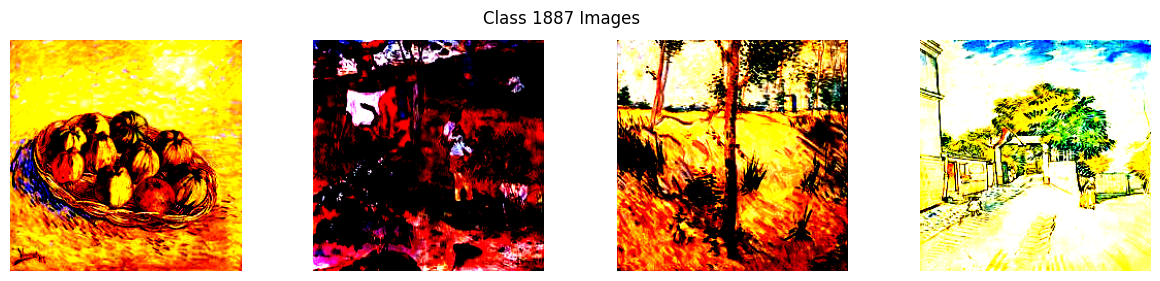

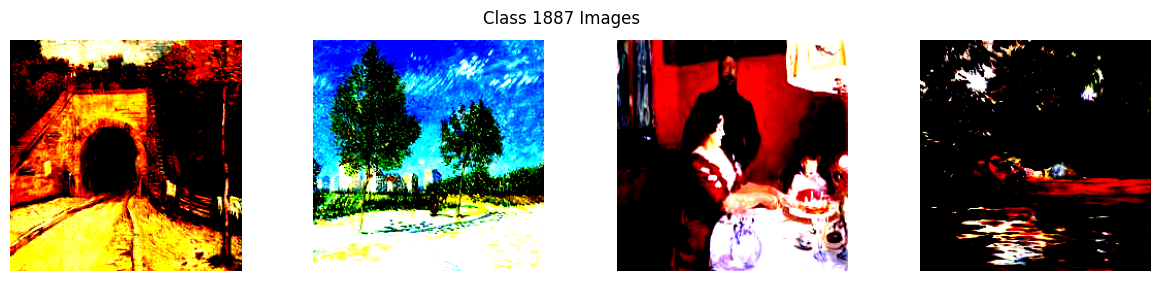

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataset, labels, class_name, num_images=4):
    # Find indices of images belonging to the specified class
    class_indices = [idx for idx, label in enumerate(labels) if label == class_name]
    # Randomly select 4 indices
    selected_indices = np.random.choice(class_indices, num_images, replace=False)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f"Class {class_name} Images")
    for i, idx in enumerate(selected_indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for visualization
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Example: Show 4 images of class 0 from the training set
show_images(train_dataset, train_labels_tensor, class_name=1887)

# Example: Show 4 images of class 1 from the testing set
show_images(test_dataset, test_labels_tensor, class_name=1887)


In [10]:
import torch

class NGDSLoss(torch.nn.Module):
    def __init__(self, margin=0.2):
        super(NGDSLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        pairwise_distances = torch.cdist(embeddings, embeddings, p=2)
        same_class_mask = labels.unsqueeze(0) == labels.unsqueeze(1)
        diff_class_mask = ~same_class_mask
        same_class_distances = pairwise_distances.masked_select(same_class_mask)
        diff_class_distances = pairwise_distances.masked_select(diff_class_mask)

        loss = torch.relu(self.margin - torch.mean(same_class_distances)) + torch.mean(diff_class_distances)
        return loss


In [ ]:
# Definición de la pérdida NGDS
class NGDSLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(NGDSLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels, indices_tuple):
        anchor, positive, negative = indices_tuple
        pos_distances = torch.norm(embeddings[anchor] - embeddings[positive], dim=1)
        neg_distances = torch.norm(embeddings[anchor] - embeddings[negative], dim=1)
        losses = F.relu(pos_distances - neg_distances + self.margin)
        return losses.mean()

# Define the CNN for feature extraction
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.pool = nn.MaxPool2d(2)

        # Calculate the output size after convolutions and pooling
        self.fc_input_size = self.calculate_fc_input_size()
        self.fc1 = nn.Linear(self.fc_input_size, 128)

    def calculate_fc_input_size(self):
        # Sample input tensor to calculate output size
        input_tensor = torch.randn(1, 3, 224, 224)  # Assuming input size of 224x224
        x = self.conv1(input_tensor)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Initialize the model, loss function, miner, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = NGDSLoss(margin=0.2)  # Utiliza la función de pérdida NGDS en lugar de TripletMarginLoss
distance = distances.CosineSimilarity()  # Define the distance metric
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")

def compute_accuracy(test_embeddings, test_labels, train_embeddings, train_labels):
    correct = 0
    total = len(test_embeddings)
    for i, test_emb in enumerate(test_embeddings):
        dists = torch.cdist(test_emb.unsqueeze(0), train_embeddings, p=2)
        min_dist_idx = torch.argmin(dists)
        if test_labels[i] == train_labels[min_dist_idx]:
            correct += 1
    accuracy = correct / total
    return accuracy

# Training loop
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch} Iteration {batch_idx}: Loss = {loss}, Number of mined triplets = {mining_func.num_triplets}")

# Function to get all embeddings
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

# Testing loop
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, test_labels, train_embeddings, train_labels, False)
    print(f"Test set accuracy (Precision@1) = {accuracies['precision_at_1']}")
    return accuracies["precision_at_1"]

# Testing and evaluation loop
num_epochs = 10
epoch_accuracies = []

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    epoch_accuracy = test(train_dataset, test_dataset, model)
    epoch_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch} Accuracy = {epoch_accuracy}")

# Print accuracy for each epoch
print("Accuracy per epoch:", epoch_accuracies)